In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [367]:
class Tree:
    def __init__(self, depth=0):
        self.f_val = None
        self.f_index = 0
        self.cat_val = None
        self.depth = depth
        self.l = None
        self.r = None

    def set_cat_val(self, cv):
        self.cat_val = cv

    def get_cat_val(self):
        return self.cat_val

    def set_left(self, l):
        self.left = l

    def set_right(self, r):
        self.right = r

    def set_val(self, val):
        self.f_val = val

    def set_val_and_index(self, val, index):
        self.f_val = val
        self.f_index = index

    def get_val_and_index(self):
        return self.f_val, self.f_index

    def get_val(self):
        return self.f_val

In [419]:
class DecisionTreeReg(torch.nn.Module):
    def __init__(self, feature_nums, cat_index=None, *args, **kwargs):
        super(DecisionTreeReg, self).__init__(*args, **kwargs)
        self.types = [0]*feature_nums
        self.tree = None
        if cat_index is not None:
            for i in cat_index:
                self.types[i] = 1

    def train(self, X, Y, max_depth=3):
        self.tree = Tree()
        rec_list = [(self.tree, X, Y)]
        while len(rec_list) and rec_list[0][0].depth < max_depth:
            node = rec_list.pop(0)
            f_i, f_val = self.best_feature_split(node[1], node[2])
            node[0].set_val_and_index(f_val, f_i)
            node[0].set_cat_val(self.max_pred(node[2]))
            xl,xr,yl,yr = self.split(node[1],node[2], f_i, f_val)
            nl = Tree(depth=node[0].depth+1)
            nr = Tree(depth=node[0].depth+1)
            node[0].set_left(nl)
            node[0].set_right(nr)
            
            if len(yl) > 0:
                rec_list.append((nl, xl, yl))
            if len(yr) > 0:
                rec_list.append((nr, xr, yr))
        return self.tree

    def predict(self, X):
        if self.tree is None:
            return None
        preds = np.empty(X.shape[0])
        for i,xi in enumerate(X):
            if (len(X.shape) > 1):
                preds[i] = self.forward(xi)
            else:
                preds[i] = self.forward([xi])
        return preds

    def forward(self, x):
        node = self.tree
        res = None
        while res is None:
            f_val, f_ind = node.get_val_and_index()
            ki = f_val == x[f_ind] if self.types[f_ind] else x[f_ind] <= f_val
            if ki:
                if node.left.cat_val is None:
                    res = node.get_cat_val()
                else:
                    node = node.left
            else:
                if node.right.cat_val is None:
                    res = node.get_cat_val()
                else:
                    node = node.right
        return res
            
    @staticmethod
    def H(Y):
        P = DecisionTreeReg.mae_predictions(Y)
        return -sum(P*np.log(P)/np.log(2))

    @staticmethod
    def IG(Y_prev, Y_curs):
        if not len(Y_prev):
            return 0
        
        r = sum([DecisionTreeReg.H(ki)*len(ki)/len(Y_prev) for ki in Y_curs])
        return DecisionTreeReg.H(Y_prev) - r
        
    @staticmethod
    def max_pred(Y):
        p = np.argmax(DecisionTreeReg.predictions(Y))
        return Y[p]

    @staticmethod
    def predictions(Y):
        if not len(Y):
            return 0
        u = sum(Y)/len(Y)
        Y2 = (Y-u)**2
        return 1 - Y2/sum(Y2)

    @staticmethod
    def mae_predictions(Y):
        if not len(Y):
            return 0
        u = sum(Y)/len(Y)
        Y2 = np.abs(Y-u)
        return 1 - Y2/sum(Y2)

    def best_feature_split(self, X, Y):
        b_val, b_ig, b_f = 0, 0, 0
        li = 1
        
        if len(X.shape) > 1:
            li = X.shape[1]
        for i in range(li):
            val, ig = self.best_line_split(X,Y,i)
            if ig > b_ig:
                b_ig = ig
                b_val = val
                b_f = i
        return b_f, b_val

    def best_line_split(self, X, Y, f_index):
        if len(X.shape) > 1:
            vals = np.unique(X[:,f_index])
        else:
            vals = np.unique(X)
        b_l = 0
        b_ig = 0
        b_val = vals[b_l]
        for i,xi in enumerate(vals):
            S = self.split(X,Y, f_index, xi)
            if (not S[2].shape[0]) or (not S[3].shape[0]):
                continue
            ig = self.IG(Y, S[2:])
            if ig > b_ig:
                b_l = i
                b_ig = ig
                b_val = xi
        return b_val, b_ig

    def split(self, X, Y, f_index, f_val):
        if len(Y.shape) > 1:
            ki = f_val == X[:,f_index] if self.types[f_index] else X[:,f_index] <= f_val
        else:
            ki = f_val == X if self.types[f_index] else X <= f_val

        xl, xr = X[ki], X[~ki]
        yl, yr = Y[ki], Y[~ki]
        return xl, xr, yl, yr
            

In [420]:
from sklearn.datasets import make_moons

In [421]:
t = DecisionTreeReg(1)
np.random.seed(10)
Y = np.random.rand(25) * 100

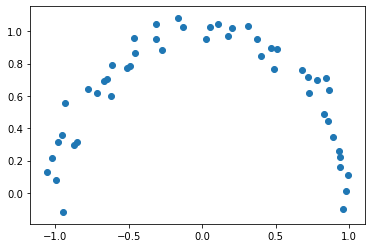

In [422]:
X, Y = make_moons(n_samples=100, noise=.05)
y = X[Y==0].T
y1 = y[1]
# print(y[0])
plt.scatter(y[0], y[1])

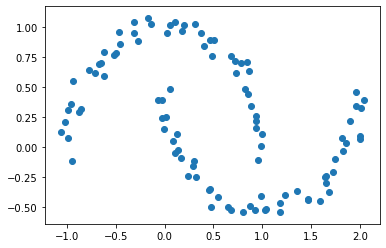

In [423]:
plt.scatter(X.T[0], X.T[1])

In [424]:
print(y1)
p = t.predictions(y1)
print(p)
P = np.sort(p)[::-1]
print(P[0])

[ 0.0132067   0.71685155  0.48691773  1.02017487  0.61553795  0.07979208
  0.10821356  0.95267268  0.55437287  1.02374926  1.0247843   0.88330803
  0.62042458  0.59660767  0.79310906  0.76236901  1.03173142  0.89169175
  1.0428858   0.16316235 -0.10222684  0.69103515  0.95258957  0.36051934
  0.31492713  0.31693484  0.64404477 -0.11615214  0.86238838  0.12995339
  0.34460598  0.77024294  0.26189121  0.21973244  0.29486727  0.78273595
  0.44723521  0.21303611  0.89593328  0.76356996  0.63352543  0.94967835
  0.70769729  1.04555855  0.9695061   0.84856441  1.07885209  0.70685054
  0.95760804  0.69879102]
[0.93477271 0.99835892 0.99684327 0.97175317 0.99999561 0.94829154
 0.95358443 0.98048923 0.99922618 0.97124565 0.97109784 0.98778737
 1.         0.99989887 0.99473228 0.99644166 0.97009596 0.98699569
 0.96845161 0.96300728 0.90762044 0.99912067 0.98049899 0.98804485
 0.98348449 0.98370079 0.99990214 0.90402636 0.98965439 0.95744015
 0.98653664 0.99603565 0.97725451 0.97159249 0.9812451 

In [425]:
print(y1)
p = t.mae_predictions(y1)
print(p)
P = np.sort(p)[::-1]
print(P[0])

[ 0.0132067   0.71685155  0.48691773  1.02017487  0.61553795  0.07979208
  0.10821356  0.95267268  0.55437287  1.02374926  1.0247843   0.88330803
  0.62042458  0.59660767  0.79310906  0.76236901  1.03173142  0.89169175
  1.0428858   0.16316235 -0.10222684  0.69103515  0.95258957  0.36051934
  0.31492713  0.31693484  0.64404477 -0.11615214  0.86238838  0.12995339
  0.34460598  0.77024294  0.26189121  0.21973244  0.29486727  0.78273595
  0.44723521  0.21303611  0.89593328  0.76356996  0.63352543  0.94967835
  0.70769729  1.04555855  0.9695061   0.84856441  1.07885209  0.70685054
  0.95760804  0.69879102]
[0.95727582 0.99322322 0.99060108 0.97188462 0.99964943 0.96196005
 0.96395949 0.97663335 0.99534651 0.97163316 0.97156035 0.98151311
 0.9999932  0.9983177  0.98785855 0.9900211  0.97107162 0.98092332
 0.97028692 0.9678251  0.94915514 0.99503939 0.9766392  0.98170904
 0.97850165 0.9786429  0.99834513 0.9481755  0.9829848  0.96548887
 0.98058954 0.98946717 0.97477061 0.97180477 0.97709046

In [426]:
from sklearn.model_selection import train_test_split

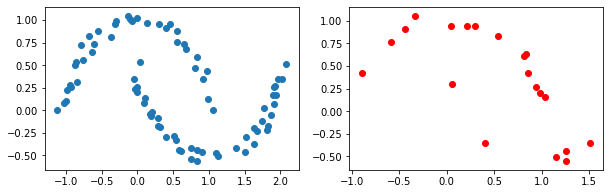

In [427]:
X, Y = make_moons(noise=0.05, n_samples=100)
DCT = DecisionTreeReg(1)
x = X[:,0]
y = X[:,1]
xtr, xte, ytr, yte = train_test_split(x,y, test_size=.2, random_state=10)
fig, axes = plt.subplots(ncols=2, figsize=(10,3))
axes[0].scatter(xtr, ytr)
axes[1].scatter(xte, yte, color='r')
# axes[2].scatter(X[:0],X[:,1], color=)

In [473]:
DCT.train(xtr, ytr, max_depth=16)

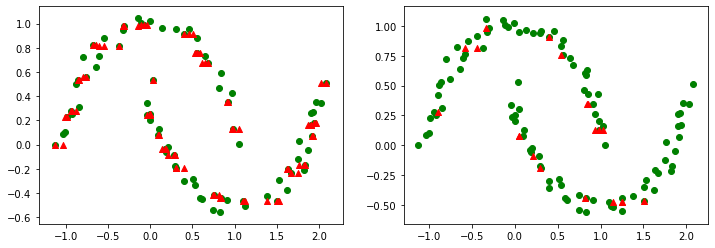

In [476]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
yp1 = DCT.predict(xtr)
yp2 = DCT.predict(xte)
axes[0].scatter(xtr, ytr, color='g')
axes[0].scatter(xtr, yp1, color='r', marker='^')

# axes[0].plot(xtr, ytr, color='g')
# axes[0].plot(xtr, yp1, color='r')

axes[1].scatter(xtr, ytr, color='g')
axes[1].scatter(xte, yte, color='g')
axes[1].scatter(xte, yp2, color='r', marker='^')


In [457]:
from sklearn.tree import DecisionTreeRegressor

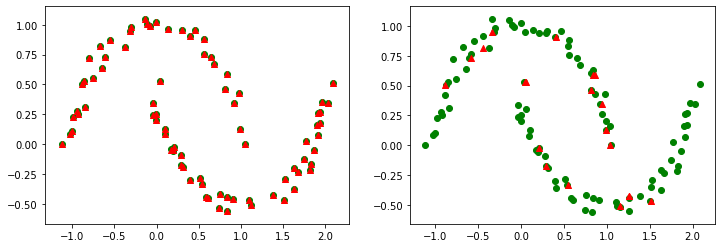

In [466]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

reg = DecisionTreeRegressor(random_state=0, max_depth=11, splitter='best', criterion='mae')
xtr2, xte2 = xtr.reshape(-1,1), xte.reshape(-1,1)
# ytr2, yte2 = ytr.reshape(-1,1), xte2.reshape(-1,1)

reg.fit(xtr2,ytr)
yp1 = reg.predict(xtr2)
yp2 = reg.predict(xte2)
axes[0].scatter(xtr2, ytr, color='g')
axes[0].scatter(xtr2, yp1, color='r', marker='^')

axes[1].scatter(xtr2, ytr, color='g')
axes[1].scatter(xte2, yte, color='g')
axes[1].scatter(xte2, yp2, color='r', marker='^')
